In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pyspark.sql import SparkSession
from pyspark.sql import dataframe
from pyspark.sql.types import StructType, StructField, DoubleType
import xgboost as xgb
import time
import glob
import json

from matplotlib import rc

rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = []
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'light'

df_dict = {}

2022-11-19 03:26:23.551155: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-19 03:26:25.666089: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software/gcc/8.2/lib64:/software/openmpi-intel/3.1.6/lib:/opt/intel/2019/compilers_and_libraries/linux/compiler/lib/intel64_lin/:/beegfs/desy/user/apaul/HEPfit/BAT_parallel/lib:/home/apaul/opt/local/lib/root:/home/apaul/opt/local/lib:/home/apaul/opt/local/lib64:
2022-11-19 03:26:25.666128: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on yo

In [13]:
# Spark session and configuration
spark = (SparkSession.builder.master("local[48]")
         .config('spark.executor.instances', 16)
         .config('spark.executor.cores', 16)
         .config('spark.executor.memory', '10g')
         .config('spark.driver.memory', '15g')
         .config('spark.memory.offHeap.enabled', True)
         .config('spark.memory.offHeap.size', '20g')
         .config('spark.dirver.maxResultSize', '20g')
         .config('spark.debug.maxToStringFields', 100)
         .appName("amp.hell").getOrCreate())

# Enable Arrow-based columnar data 
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark.conf.set(
    "spark.sql.execution.arrow.pyspark.fallback.enabled", "true"
)


def loadData(dim=8, spark=spark):
    # read the data into a spark frame
    start = time.time()
    path = '../data/'
    header = ['x'+str(i+1) for i in range(dim)] + ['yN', 'y_2'] 
    schema = StructType([StructField(header[i], DoubleType(), True) for i in range(dim+2)])
    df = spark.read.options(delimiter=',').schema(schema).format("csv").load(path+str(dim)+'D'+'/test/*.csv.*', header='true')

    print('INFO: '+str(dim)+'D data loaded into Spark session in {:.3f} seconds'.format(time.time() - start))

    # transfer the data to a pandas dataframe
    start = time.time()
    df_p = df.limit(1000000).toPandas() 
    print('INFO: '+str(dim)+'D data loaded into pandas dataframe in {:.3f} seconds'.format(time.time() - start))
    return df_p


def testModel(path: str, df_dict=df_dict, column='yN'):
#     df = df_in.copy(deep=True)
    if any(x in path for x in ['dnn', 'skip']):
        # load the model
        regressor = tf.keras.models.load_model(glob.glob(path+'/dnn-*.tfm.hdf5')[0])
        # load the best weights
        regressor.load_weights(glob.glob(path+'/checkpoint-*.hdf5')[0])
        #load the config file
        with open(glob.glob(path+'/config*.json')[0]) as f:
            config = json.load(f)
        key = str(config['input_shape']) +'-'+ str(config['model_type']) +'-'+ str(config['depth']) + '-' + str(int(config['sample-size']/1e6))
        
    if 'bdt' in path:
        # load the model
        regressor = xgb.XGBRegressor()
        regressor.load_model(glob.glob(path+'/bdt*.ubj')[0])
        #load the config file
        with open(glob.glob(path+'/config*.json')[0]) as f:
            config = json.load(f)
        key = str(config['input_shape']) +'-bdt-'+ str(config['max_depth']) + '-' + str(int(config['sample-size']/1e6))
            
    df = df_dict[str(config['input_shape'])].copy(deep=True)
    
    if config['scaled'] == 'normal':
        df['y_pred'] = regressor.predict(df[['x'+str(i+1) for i in range(config['input_shape'])]]) * config['sigma'] + config['mu']
    elif config['scaled'] == 'log':
        df['y_pred'] = np.exp(regressor.predict(df[['x'+str(i+1) for i in range(config['input_shape'])]]) * config['sigma'] + config['mu'])
    else:
        df['y_pred'] = regressor.predict(df[['x'+str(i+1) for i in range(config['input_shape'])]])
        
    df['relative_error'] = df['y_pred']/df[column] - 1
    df['relative_percentage_error'] = df['relative_error'] * 100
    
    data[key] = {}
    data[key]['config'] = config
    data[key]['df'] = df


def labeler(index: str, t=0) -> str:
    if t == 0:
        return '{}-{} ({:,})'.format(data[index]['config']['depth'], data[index]['config']['width'], data[index]['config']['trainable_parameters'])
    else:
        return 'max-depth: {}'.format(str(data[index]['config']['max_depth']))
    
    
def getErrorTail(bound: float):
    errorTails = {}
    for key in data.keys():
        errorTails[key] = {}
        errorTails[key]['type'] = data[key]['config']['model_type'] if 'model_type' in data[key]['config'].keys() else 'bdt'
        errorTails[key]['dim'] = data[key]['config']['input_shape']
        errorTails[key]['depth'] = data[key]['config']['depth'] if 'depth' in data[key]['config'].keys() else data[key]['config']['max_depth']
        errorTails[key]['width'] = data[key]['config']['width'] if 'width' in data[key]['config'].keys() else ''
        errorTails[key]['sample'] = data[key]['config']['sample-size']
        errorTails[key]['error < '+str(bound)+'%'] = np.round((data[key]['df'][abs(data[key]['df']['relative_percentage_error']) < bound].shape[0]/data[key]['df'].shape[0])*100, 2)
        errorTails[key]['$\mu_{error}$ (%)'] = (np.round(data[key]['df']['relative_percentage_error'].abs().mean(), 4))
        errorTails[key]['$\sigma_{error}$ (%)'] = np.round(data[key]['df']['relative_percentage_error'].std(), 2)
    return errorTails

In [3]:
df_dict['2'] = loadData(2)
df_dict['4'] = loadData(4)
df_dict['8'] = loadData(8)
files = sorted(glob.glob('../src/dnn/RUNS-sample-size-II/*leaky_relu*'))

INFO: 2D data loaded into Spark session in 4.086 seconds


INFO: 2D data loaded into pandas dataframe in 6.809 seconds
INFO: 4D data loaded into Spark session in 0.329 seconds


INFO: 4D data loaded into pandas dataframe in 6.008 seconds
INFO: 8D data loaded into Spark session in 0.291 seconds


INFO: 8D data loaded into pandas dataframe in 6.765 seconds


In [4]:
data = {}

for file in files:
    testModel(file, df_dict)

2022-11-19 03:27:47.689077: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software/gcc/8.2/lib64:/software/openmpi-intel/3.1.6/lib:/opt/intel/2019/compilers_and_libraries/linux/compiler/lib/intel64_lin/:/beegfs/desy/user/apaul/HEPfit/BAT_parallel/lib:/home/apaul/opt/local/lib/root:/home/apaul/opt/local/lib:/home/apaul/opt/local/lib64:
2022-11-19 03:27:47.689285: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-19 03:27:47.689322: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (max-wne001.desy.de): /proc/driver/nvidia/version does not exist
2022-11-19 03:27:47.690029: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

31250/31250 [==============================] - 27s 861us/step


In [8]:
bdt_files = sorted(glob.glob('../src/bdt/RUNS-sample-size-II/*-yN-normal*'))

In [9]:
for file in bdt_files:
    testModel(file, df_dict)

In [29]:
errorTails = getErrorTail(1)

In [15]:
df_data = pd.DataFrame(columns=['type', 'dim', 'depth', 'num_trees', 'sample', 'delta1', 'absdelta'])
for key in errorTails.keys():
    df_data.loc[len(df_data)] = [errorTails[key]['type'], errorTails[key]['dim'], errorTails[key]['depth'], errorTails[key]['width'], errorTails[key]['sample'],
                                 errorTails[key]['error < 1%'], errorTails[key]['$\mu_{error}$ (%)']]

In [26]:
ex_files = sorted(glob.glob('../src/dnn/dv-back/*-normal-*'))

In [28]:
for file in ex_files:
    testModel(file, df_dict)

31250/31250 [==============================] - 27s 851us/step


In [21]:
df_2D = pd.read_csv('../../machine-casting/results/data-volume-bdt-2D.csv')
df_4D = pd.read_csv('../../machine-casting/results/data-volume-bdt-4D.csv')
df_8D = pd.read_csv('../../machine-casting/results/data-volume-bdt-8D.csv')

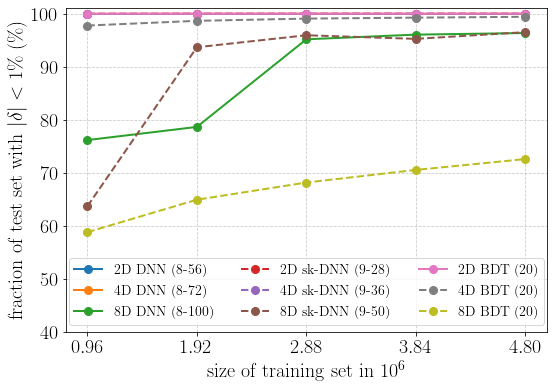

In [31]:
plt.figure(figsize=(8,5.5))
linewidth = 2
markersize = 8
fact = 1e6/0.8/0.6
pdf = df_data[(df_data['type'] == 'dnn') & (df_data['dim'] == 2)][['sample', 'delta1']].sort_values(by='sample')
plt.plot(pdf['sample']/fact, pdf['delta1'], linewidth=linewidth, label='2D DNN (8-56)', marker= 'o', markersize=markersize)

pdf = df_data[(df_data['type'] == 'dnn') & (df_data['dim'] == 4)][['sample', 'delta1']].sort_values(by='sample')
plt.plot(pdf['sample']/fact, pdf['delta1'], linewidth=linewidth, label='4D DNN (8-72)', marker= 'o', markersize=markersize)

pdf = df_data[(df_data['type'] == 'dnn') & (df_data['dim'] == 8)][['sample', 'delta1']].sort_values(by='sample')
plt.plot(pdf['sample']/fact, pdf['delta1'], linewidth=linewidth, label='8D DNN (8-100)', marker= 'o', markersize=markersize)

pdf = df_data[(df_data['type'] == 'skip') & (df_data['dim'] == 2)][['sample', 'delta1']].sort_values(by='sample')
plt.plot(pdf['sample']/fact, pdf['delta1'], linewidth=linewidth, label='2D sk-DNN (9-28)', marker= 'o', markersize=markersize, linestyle='dashed')

pdf = df_data[(df_data['type'] == 'skip') & (df_data['dim'] == 4)][['sample', 'delta1']].sort_values(by='sample')
plt.plot(pdf['sample']/fact, pdf['delta1'], linewidth=linewidth, label='4D sk-DNN (9-36)', marker= 'o', markersize=markersize, linestyle='dashed')

pdf = df_data[(df_data['type'] == 'skip') & (df_data['dim'] == 8)][['sample', 'delta1']].sort_values(by='sample')
plt.plot(pdf['sample']/fact, pdf['delta1'], linewidth=linewidth, label='8D sk-DNN (9-50)', marker= 'o', markersize=markersize, linestyle='dashed')

plt.plot(df_2D['0'], df_2D['1'], marker='o', linewidth=2, markersize=8, label=r'2D BDT (20)')

pdf = df_data[(df_data['type'] == 'bdt') & (df_data['dim'] == 4)][['sample', 'delta1']].sort_values(by='sample')
plt.plot(pdf['sample']/fact, pdf['delta1'], linewidth=linewidth, label='4D BDT (20)', marker= 'o', markersize=markersize, linestyle='dashed')

pdf = df_data[(df_data['type'] == 'bdt') & (df_data['dim'] == 8)][['sample', 'delta1']].sort_values(by='sample')
plt.plot(pdf['sample']/fact, pdf['delta1'], linewidth=linewidth, label='8D BDT (20)', marker= 'o', markersize=markersize, linestyle='dashed')


# plt.plot(df_4D['0'], df_4D['1'], marker='o', linewidth=2, markersize=8, label=r'4D BDT')
# plt.plot(df_8D['0'], df_8D['1'], marker='o', linewidth=2, markersize=8, label=r'8D BDT')

plt.legend(fontsize=14, loc='lower center', ncol=3)
plt.xlabel(r'size of training set in $10^6$', fontsize=20)
plt.ylabel(r'fraction of test set with $|\delta| < 1\% \;(\%)$', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
# plt.xscale('log')
# plt.yscale('log')
plt.ylim(40, 101)

plt.xticks(pdf['sample'].values/fact, fontsize=20)
plt.grid(linestyle='dashed', alpha=0.4, color='#808080')
plt.tight_layout()
plt.savefig('../plots/data-volume.pdf', dpi=300)
plt.show()